### 📌 About this kernel

* This kernel shows the implementation of Gradient based Class Activation Map(CAM) as a custom Keras Callback. 
* It uses a toy Cat Vs Dog dataset(Binary Classification).
* This can be slighly modified to be used in a multi-class and multi-label setting. 

### ⌛ Upcoming

Working on a kernel to use this callback for multi-label classification of HPA dataset.

### 💡 GradCAM visualization

![](https://i.imgur.com/LWFcT1Y.gif)

# 🎅 Gradient Based Class Activation Map(GradCAM): Intro

### [More on CAM and GradCAM here $\rightarrow$](https://wandb.ai/ayush-thakur/interpretability/reports/Interpretability-in-Deep-Learning-With-W-B-CAM-and-GradCAM--Vmlldzo5MTIyNw)

Thus the authors of [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf), a really amazing paper, came up with modifications to CAM and previous approaches. Their approach uses the gradients of any target prediction flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the class of the image. 

Thus Grad-CAM is a strict generalization over CAM. Besides overcoming the limitations of CAM it's applicable to different deep learning tasks involving CNNs:

* CNNs with fully-connected layers (e.g. VGG) without any modification to the network.
* CNNs used for structured outputs like image captioning.
* CNNs used in tasks with multi-modal inputs like visual Q&A or reinforcement learning, without architectural changes or re-training.

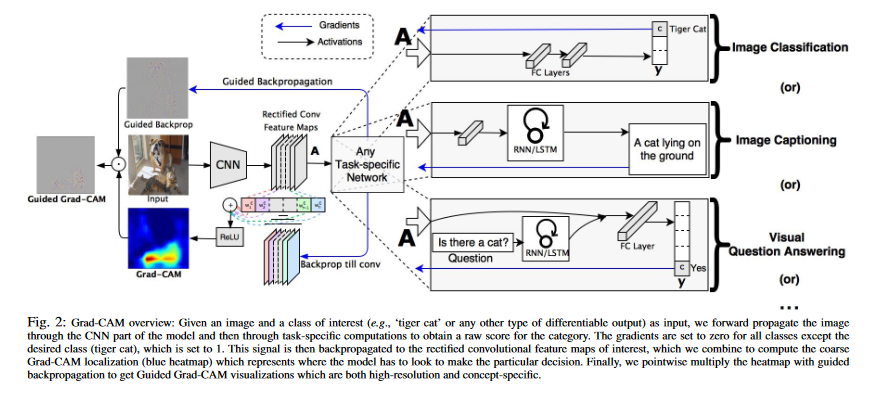
([Source](https://arxiv.org/pdf/1610.02391.pdf))

# 🧰 Imports, Installations and Setups

In [ ]:
%%capture
!pip install wandb

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Imports for augmentations. 
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, Rotate
)

In [ ]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api")

wandb.login(key=wandb_api)

# 📀 Download Cat and Dog Dataset

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

In [ ]:
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

# 🌋 Prepare Dataloader

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Define the augmentation policies. Note that they are applied sequentially with some probability p.
transforms = Compose([
            Rotate(limit=30),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5)
        ])


# Apply augmentation policies.
def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    
    return aug_img

# Augmentation policies
def apply_augmentation(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    aug_img.set_shape((IMG_HEIGHT, IMG_WIDTH, 3))
    
    return aug_img, label

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Preprocess image
def preprocess_data(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image/255.0
    image = tf.squeeze(image, 0)
    
    label = tf.squeeze(label, -1)
    
    return image, label

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='binary', color_mode='rgb', batch_size=1, image_size=(IMG_HEIGHT, IMG_WIDTH), shuffle=True
).map(preprocess_data, num_parallel_calls=AUTOTUNE).map(apply_augmentation, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir, labels='inferred', label_mode='binary', color_mode='rgb', batch_size=1, image_size=(IMG_HEIGHT, IMG_WIDTH), shuffle=True, seed=42
).map(preprocess_data, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

In [ ]:
def show_batch(image_batch):
  plt.figure(figsize=(20,20))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')
    
image_batch, image_label = next(iter(train_ds))
show_batch(image_batch)

# 🐤 Model

In [ ]:
def catdogmodel():
  inp = keras.layers.Input(shape=(224,224,3))
  vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=inp,
                                            input_shape=(224,224,3))
  vgg.trainable = False
  
  x = vgg.get_layer('block5_pool').output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.models.Model(inputs = inp, outputs=output)

  return model

keras.backend.clear_session()
model = catdogmodel()
model.summary()

# 💎 GradCAM Callback

In [ ]:
## Reference: https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
class GradCAM:
  def __init__(self, model, layerName):
    self.model = model
    self.layerName = layerName
    
    self.gradModel = keras.models.Model(inputs=[self.model.inputs], 
                                        outputs=[self.model.get_layer(self.layerName).output, self.model.output])
    
  def compute_heatmap(self, image, classIdx, eps=1e-8):
    
    with tf.GradientTape() as tape:
      tape.watch(self.gradModel.get_layer(self.layerName).variables)
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = self.gradModel(inputs)

      if len(predictions)==1:
        # Binary Classification
        loss = predictions[0]
      else:
        loss = predictions[:, classIdx]
    
    grads = tape.gradient(loss, convOutputs)
    
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    
    return heatmap
    
  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_HOT):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    
    return (heatmap, output)

In [ ]:
class GRADCamLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, layer_name):
      super(GRADCamLogger, self).__init__()
      self.validation_data = validation_data
      self.layer_name = layer_name

    def on_epoch_end(self, logs, epoch):
      images = []
      grad_cam = []

      ## Initialize GRADCam Class
      cam = GradCAM(model, self.layer_name)

      for image in self.validation_data:
        image = np.expand_dims(image, 0)
        pred = model.predict(image)
        classIDx = np.argmax(pred[0])
  
        ## Compute Heatmap
        heatmap = cam.compute_heatmap(image, classIDx)
        
        image = image.reshape(image.shape[1:])
        image = image*255
        image = image.astype(np.uint8)

        ## Overlay heatmap on original image
        heatmap = cv2.resize(heatmap, (image.shape[0],image.shape[1]))
        (heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.5)

        images.append(image)
        grad_cam.append(output)

      wandb.log({"images": [wandb.Image(image)
                            for image in images]})
      wandb.log({"gradcam": [wandb.Image(cam)
                            for cam in grad_cam]})

In [ ]:
## Prepare sample images to run your GradCam on. 
sample_images, sample_labels = next(iter(val_ds))
sample_images.shape, sample_labels.shape

# ♣️ Callback

In [ ]:
earlystoper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=0, mode='min',
    restore_best_weights=True
)

# 🚋 Train with W&B

In [ ]:
# Initialize model
keras.backend.clear_session()
model = catdogmodel()

# Compile model
model.compile('adam', 'binary_crossentropy', ['acc'])

# Intialize W&B run
wandb.init(project='gradcam')

# Train model
history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    callbacks=[WandbCallback(data_type="image", validation_data=(sample_images, sample_labels)),
                               GRADCamLogger(sample_images, layer_name='block5_conv3')])

# Close W&B run
wandb.finish()